In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots, savefig
import richardsplot as rplot
from k2utils import *
import matplotlib.ticker as ticker
import multiprocessing
from multiprocessing.pool import ThreadPool
from numpy.fft import fft2
from scipy import fftpack, ndimage



MAG_RANGE = {'noise':(30,20),'AGN':(20,16),'stars':(16,10), 'all':(100,1), '17-18':(18,17)}
rc('animation', html='html5') 


In [2]:
# Some user settings
#field = 'RAW_CNTS'
field = 'FLUX'
campaign = 8
#module=4
#channel=3 #Index of the channel

#module = 17 #This is the next one, on the dwarf galaxy, hopefully lots of objects
#channel = 1

channel=2
module=6

N=3853 # The total number of available frames
#N=2353

ccd = CCD(campaign=campaign, field=field, channel=channel, module=module)

objs = getObjects(ccd) # Dictionary of objects
print "Channel From File:",Field.get_channels(ccd.module)[ccd.channel]
print "Number of Objects:",len(objs.items())
loader = LoadingBar()
loader.set_as_bar()

Found 24137 objects from VJ database 
Found 50 objects from GO_all_campaigns_to_date.csv 
Removed 23879 objects from outside the ccd region 
Channel From File: 15
Number of Objects: 308


## Load campagin 8 hdf5

In [3]:
pixmapfile = '/media/jackeline/UUI/PixelMaps/rachelMaps/K2PixelMap_8.hdf5'
ccd = CCD(campaign=campaign, field=field, channel=channel, module=module)            
cont = PixelMapContainer.from_hdf5(pixmapfile, ccd)
gen = PixMapGenerator(cont)

## Analysis and Plotting Functions

In [4]:

def running_func(func,x,N, **func_kwargs):
    
    n,m = N/2, N%2
    return np.array([func(x[i-n if i > n else i:i+n+m], **func_kwargs) for i in xrange(len(x))])

runningMean = partial(running_func,np.nanmedian)
#def runningMean(x,N):
#    return np.array([np.nanmedian(x[i-N/2 if i > N/2 else i:i+N/2+(N%2)]) for i in xrange(len(x))])

def runningStd(x,N):
    return np.array([np.nanstd(x[i-N/2 if i > N/2 else 0:i+N/2 +(N%2)]) for i in xrange(len(x))])



def plotNiceIntervals(ax,x,y,N=30, label=None, color=None):
    if color is None:
        color = next(ax._get_lines.prop_cycler)['color']
    rm = runningMean(y,N)
    #rs = runningStd(y,N)
    #rs = runningMean(rs,N) #Make it nice and smooth
    
    ax.plot(x, y, ls=' ', marker='.', ms=1, color=color)
    #ax.fill_between(x, rm+rs, rm-rs, color=color, alpha=0.1, linestyle='None')
    ax.plot(x, rm, ls='-', color=color, lw=2, label=label)
    #ax.plot(x, rm, ls='-', color=color, lw=1, marker='.', ms=1)
    #ax.set_xlim(min(x), max(x))
    #ax.set_ylim(np.nanmean(rm)-np.nanstd(rm)*3, np.nanmean(rm)+np.nanstd(rm)*3)
    
#----------------------Plotting 
from multiprocessing import Pool
def axes_prop_setter(local_vars, *args, **kwargs):

    locals().update(local_vars)
    for key, value in kwargs.iteritems():
        if hasattr(value, '__iter__'):
            value = iter(value)
        elif type(value) is str:
            if value.startswith('@'): # for custom expressions
                value = eval(value[1:])
        else:
            value = iter([value])
        eval('ax.{}(*value)'.format(key))
    for arg in args:
        eval('ax.{}()'.format(arg))
        

class GPLCMP_contatiner:
    
    gen = None
    percentiles = None
    mag_range = None
    higher = None
    lower = None
    ccd = None
    M = None
    lc = None
    
    @classmethod
    def reinit(cls, gen, percentiles, mag_range=None):
        GPLCMP_contatiner.gen = gen
        GPLCMP_contatiner.percentiles = percentiles
        GPLCMP_contatiner.mag_range = mag_range
        GPLCMP_contatiner.higher,  GPLCMP_contatiner.lower = None, None
        if mag_range is None:
            GPLCMP_contatiner.higher, GPLCMP_contatiner.lower = np.inf, -np.inf
        else:
            GPLCMP_contatiner.higher, GPLCMP_contatiner.lower = magToFlux(np.array(sorted(mag_range)))

        GPLCMP_contatiner.ccd = gen.ccd
        GPLCMP_contatiner.M = len(percentiles)-1

        GPLCMP_contatiner.lc = np.empty((N,GPLCMP_contatiner.M,5)) # min, max, var, median, mean
        GPLCMP_contatiner.lc[::] = np.nan

    @classmethod
    def get_stats(cls, index):
        g = GPLCMP_contatiner.gen.get_unordered(index)
        stats = np.empty((GPLCMP_contatiner.M, 5))
        m = (g > GPLCMP_contatiner.lower) & (g < GPLCMP_contatiner.higher)
        if m.any():
            p = np.percentile(g[m], GPLCMP_contatiner.percentiles)
            stats[:,:2] = zip(p[:-1], p[1:])
            
            # New
            for j, (low, high) in enumerate(stats[:,:2]):
                cut = g[(g > low) & (g < high)]
                if len(cut):
                    stats[j,2] = np.var(cut)
                    stats[j,3] = np.median(cut)
                    #lc[i,j,4] = np.dot(cut,np.ones(len(cut)))/len(cut)
                    stats[j,4] = np.mean(cut)
                    
        return index, stats
    
    @classmethod
    def apply_to_lc(cls, result):
        i, value = result
        GPLCMP_contatiner.lc[i] = value
    
def run_GPLCMP_func(index):
    
    return GPLCMP_contatiner.get_stats(index)

def get_pixel_lc_mp(gen, percentiles, mag_range=None):
    '''percentiles is a flat array of percentiles ranging from 0 to 100'''
    GPLCMP_contatiner.reinit(gen, percentiles, mag_range)
    P = Pool(4)
    for result in P.imap_unordered(run_GPLCMP_func, xrange(N), N/32):
        GPLCMP_contatiner.apply_to_lc(result)
        
    return GPLCMP_contatiner.lc

def get_pixel_lc(gen, percentiles, mag_range=None):
    '''percentiles is a flat array of percentiles ranging from 0 to 100'''

    higher, lower = None, None
    if mag_range is None:
        higher, lower = np.inf, -np.inf
    else:
        higher, lower = magToFlux(np.array(sorted(mag_range)))
    if np.inf in mag_range:
        lower = -np.inf
    
    ccd = gen.ccd
    M = len(percentiles)-1
    
    lc = np.empty((N,M,5)) # min, max, var, median, mean
    lc[::] = np.nan
        
    funcs = (np.var, np.median, np.mean)
    
    for i,g in enumerate((gen.get_unordered(i) for i in xrange(N))):
        m = (g > lower) & (g < higher)
        if m.any():
            p = np.percentile(g[m], percentiles)
            lc[i,:,:2] = zip(p[:-1], p[1:])
            
            # New
            for j, (low, high) in enumerate(lc[i,:,:2]):
                cut = g[(g > low) & (g < high)]
                if len(cut):
                    lc[i,j,2] = np.var(cut)
                    lc[i,j,3] = np.median(cut)
                    #lc[i,j,4] = np.dot(cut,np.ones(len(cut)))/len(cut)
                    lc[i,j,4] = np.mean(cut)
    return lc

def make_pixel_lc(lc, percentiles, stat='median', diff=False, med_norm=False):

    t = 0.02043229*np.arange(N)+2559.06849083
    bins = np.array(zip(percentiles[:-1], percentiles[1:]))
    bins = filter(lambda x: None not in x, bins) # for percentiles containing Nones
    idx = {'var':2, 'median':3, 'mean':4}[stat]
    stat = np.empty((2,)) # so we can keep track of the median magnitudes between percentiles
    y = np.empty((N,))
    
    for i,b in enumerate(bins):
        y[::] = lc[:,i,idx]
        stat[::] = [np.nanmedian(lc[:,i,0]),np.nanmedian(lc[:,i,1])]
        
        if diff and i:
            y[::] -= lc[:,i-1,idx]
            stat[::] = np.nanmean([stat,[np.nanmedian(lc[:,i-1,0]),np.nanmedian(lc[:,i-1,1])]], axis=0)

        if med_norm: # divide out by mean
            y[::] /= np.nanmedian(y)
        else:
            med = np.nanmedian(y)
            std = np.nanstd(y)
            y[::] = (y-med)/std
        
        label = '{:.2f}\% to {:.2f}\%, KepMag: {:.2f} to {:.2f}'.format(*(tuple(b)+tuple(fluxToMag(stat))))
        yield t,copy(y),label,copy(stat)
    
def set_tick_sizes(ax):
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(26) 

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

def plot_pixel_lc(args, title=None, ylim=None, ax = None, *axargs, **axkwargs):
    
    if ax is None:
        fig, ax = subplots(1,1, figsize=(16,9))
    else:
        fig = ax.figure
    ax.set_prop_cycle(color=rplot.palettable.cubehelix.perceptual_rainbow_16.mpl_colors)
    #ax.set_prop_cycle(color=rplot.palettable.colorbrewer.sequential.YlGnBu_6.mpl_colors)
    for t, y, label, b in args:
        plotNiceIntervals(ax, t, y, label=label, N=120)
    
    if title is not None:
        ax.set_title(title, fontsize=30)
        
    ax.set_xlabel('Date', fontsize=24)
    ax.set_ylabel('Flux (Median Normalized)', fontsize=24)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlim(min(t), max(t))
    #legend = ax.legend(fontsize=26)
    #for line in legend.get_lines():
    #    line.set_alpha(1)
    #    line.set_marker('.')
    axes_prop_setter(locals(), *axargs, **axkwargs)
    set_tick_sizes(ax)
    return fig, ax
    
def plot_pixel_image(args, title=None, ylim=None, STEP=120, smooth=False):
    
    import matplotlib.pyplot as plt
    fig, ax = subplots(1,1, figsize=(16,9))
    args = list(args)
    
    image = np.array([y for t,y,_,b in args][::-1])
    
    #print image
    if smooth: # This is very very slow
        #image[::] = np.array([runningMean(y,120) for y in image])
        image = np.array(runningMean(image.T,120,axis=0)).T
    if STEP > 1:
        image = np.array([np.mean(image[:,i:i+STEP], axis=1) for i in xrange(0,image.shape[1],STEP)]).T
        
    col, row = image.shape
    t = 0.02043229*np.arange(N)+2559.06849083

    #cmap = rplot.palettable.colorbrewer.diverging.BrBG_11.mpl_colormap
    cmap = rplot.palettable.cubehelix.perceptual_rainbow_16.mpl_colormap
    if ylim is not None:
        im = ax.imshow(image, cmap=cmap, vmin=ylim[0], vmax=ylim[1], aspect='auto')
        cbar=fig.colorbar(im, ticks=np.linspace(ylim[0],ylim[1], 1+(ylim[1]-ylim[0])))
    else:
        im = ax.imshow(image, cmap=cmap, aspect='auto')
        cbar = fig.colorbar(im)
    if title is not None:
        ax.set_title(title)
    

        
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: int((col-1-y)*100/col+0.5)))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: int(x*1.0/row*N*0.02043229+2559.06849083)))
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Percentile')
    print ax.get_ylim()
    
    if args[0][3] is not None:
        bins = np.array([bins for _,_,_,bins in args][::-1])
        #print bins.shape
        axis_labels = fluxToMag(np.mean(bins, axis=1))[::-1]
        #print axis_labels
        #ax.tick_params(labelbottom='on',labeltop='off', labelleft="on", 
        #    top='off', left='on', right='off')
        #ax2 = fig.add_axes(ax.get_position(), frameon=False)
        ax2 = ax.twinx()
        #ax2.tick_params(labelbottom='off',labeltop='off', labelleft="off", labelright='on',
        #    bottom='off', left='off', right='on', which='both')
        
        #ax2.set_ylim(ax.get_ylim())
        #ax2.set_xlim(ax.get_xlim())
        #plt.draw()
        #ax2.set_position(ax.get_position())
        #plt.draw()
        #print axis_labels
        ax.autoscale(False)
        ax2.autoscale(False)
        def formatter(x, pos):
            #print x
            if pos is None:
                return ''
            idx = int(x*len(axis_labels)+0.5)
            if idx >= len(axis_labels) or idx < 0:
                return ''
            #print "{:.2f}".format(axis_labels[idx])
            return "{:.1f}".format(axis_labels[idx])
        ax2.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))
        #ax2.yaxis.set_label_position("right")
        #ax2.set_ylim(ax.get_ylim())
        #ax2.set_ylim(axis_labels[0], axis_labels[-1])
        #ax2.yaxis.set_view_interval(axis_labels[0], axis_labels[-1])
        #ax2.set_adjustable('box-forced')
        #plt.draw()
        
        #print "ax2:",ax2.get_ylim()
        #print "ax: ",ax.get_ylim()
        #ax2.set_ylabel('Kep Mag')
    
    return image
    


def make_pixel_hist(gen, percentiles, bins=None, mag_range=None, ax=None, **hist_kwargs):
    '''masks are a list of functions'''
    
    data = np.concatenate([gen.get_unordered(i) for i in xrange(N)])

    if mag_range is not None:
        low, high = magToFlux(np.array(mag_range))
        data = data[(data > low) & (data < high)]
    else:
        data = data[data>0.1] # so we don't have rediculous magnitude values
        
    data = fluxToMag(data)

    hist, bins = np.histogram(data, bins=bins)
    edges = np.percentile(data, percentiles)
    edges = zip(edges[:-1], edges[1:])
    
    masks = (lambda x: (x < high) & (x > low) for low, high in edges)

    if ax is None:
        fig, ax = subplots(1,1, figsize=(12,8))
    else:
        fig = ax.figure

    width = bins[1]-bins[0]
    print bins.shape, hist.shape, len(edges)
    print bins[-2:], edges[-1]
    for i,m in enumerate(masks):

        ma = m(bins[:-1])
        b = bins[:-1][ma]
        h = hist[ma]
        #print min(b),max(b),
        #print b
        x = [x_ for edge in zip(b[:-1], b[1:]) for x_ in edge]
        y = [y_ for edge in zip(h[:-1], h[1:]) for y_ in edge]
        if x:
            x = [x[0]] + x + [x[-1]]
            y = [0] + y + [0]
        
        color = next(ax._get_lines.prop_cycler)['color']
        p = [percentiles[i], percentiles[i+1]]
        if 'orientation' in hist_kwargs:
            if hist_kwargs['orientation'] == 'vertical':
                x, y = y, x
        ax.plot(x,y,label=percentile_mask(*p).__doc__, color=color)
        
        #print " N:", np.sum(h)

    ylim = ax.get_ylim()
    ax.set_ylim(0,ylim[1])
    ax.legend(fontsize=26)
    ax.set_xlabel('KepMag', fontsize=28)
    ax.set_ylabel('Pixels', fontsize=28)
    ax.text(28,100000, 'CCD Module:{}, Channel:{}'.format(ccd.module, ccd.channel+1), fontsize=25)

    #ax.set_title('K2 CCD Flux Percentiles\n Module:{}, Channel:{}'.format(ccd.module, ccd.channel+1), fontsize=30)
    set_tick_sizes(ax)
    return fig, ax
    

In [5]:
mode = 'percentiles'


# Magnitude binned lightcurves for "empty" pixels

In [6]:
from matplotlib.pyplot import savefig
from matplotlib.colors import BoundaryNorm
from matplotlib import colorbar
p = (0,100)
p = np.arange(0,110, 10)
lc_ = get_pixel_lc(gen, p, mag_range=(20, 35))
args = list(make_pixel_lc(lc_, p, stat='median', diff=False, med_norm=False))

/home/jackeline/anaconda2/envs/test_JacksPackage/lib/python2.7/site-packages/ipykernel/__main__.py:153: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


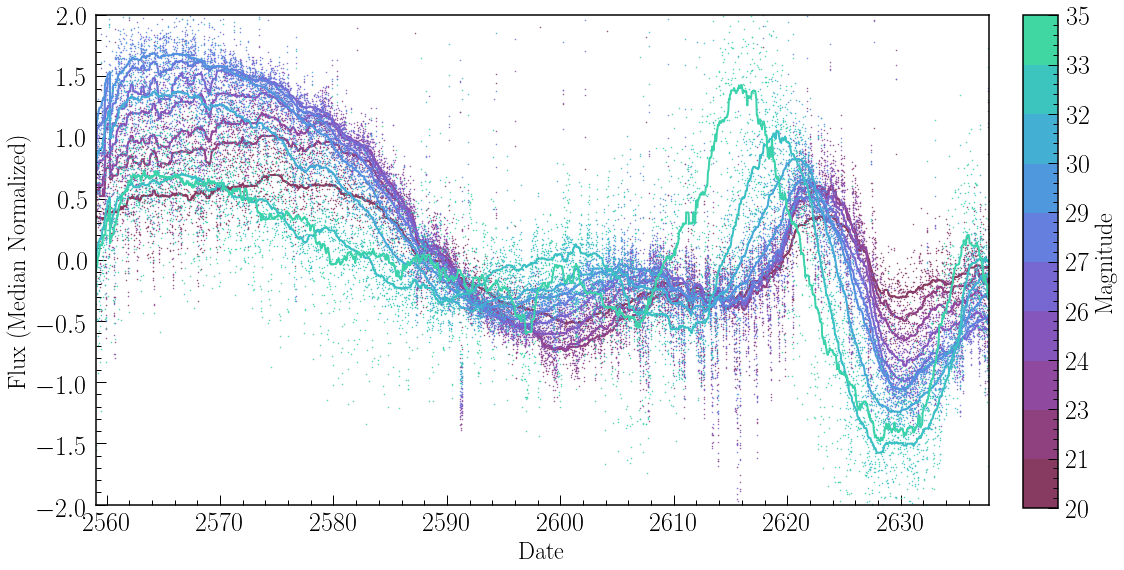

In [7]:

#fig, ax = plot_pixel_lc(args, title="Median Pixel Light Curve\nKepler K2 Campaign 8, Module %i, Channel %i" % (gen.ccd.module, gen.ccd.channel+1), ylim=(-2,2))
fig, ax = plot_pixel_lc(args, title=None, ylim=(-2,2))

cmap = rplot.palettable.cubehelix.perceptual_rainbow_16.mpl_colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(20,35,11)
norm = BoundaryNorm(bounds, 160)
ax2 = fig.add_axes([0.93, 0.12, 0.03, 0.76])
cb = colorbar.ColorbarBase(ax2, cmap=cmap, 
                           norm=norm, spacing='proportional', 
                           ticks=bounds, boundaries=bounds, 
                           format='%1i')

ax2.set_ylabel('Magnitude', fontsize=24)
cb.ax.tick_params(labelsize=26)
for i in xrange(10):
    ax.lines[-2*i].set_visible(True)


#savefig('../plots/medianPercentile.pdf', bbox_inches='tight')

# Histogram

(401,) (400,) 3
[ 41.26446585  41.33856964] (19.142091751098633, 41.338569641113281)


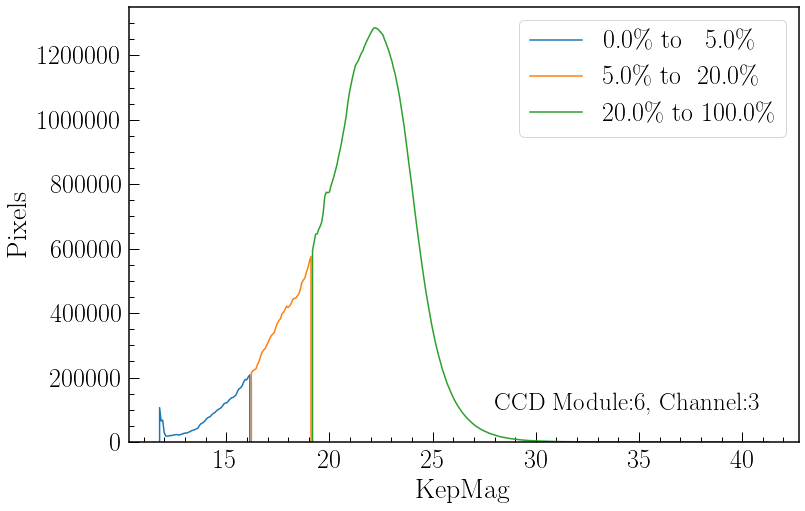

In [8]:
percentiles = range(0,125,25)
percentiles = (0, 5, 20, 100)
#percentiles = []
#percentiles = np.arange(0, 100.5, 0.5)
fig_hist, ax_hist = make_pixel_hist(gen, percentiles, bins=100*len(percentiles), mag_range=MAG_RANGE['all'])
#fig_hist.savefig('../plots/percentilehistogram.pdf', dpi = 200)

# Vizualize CCD

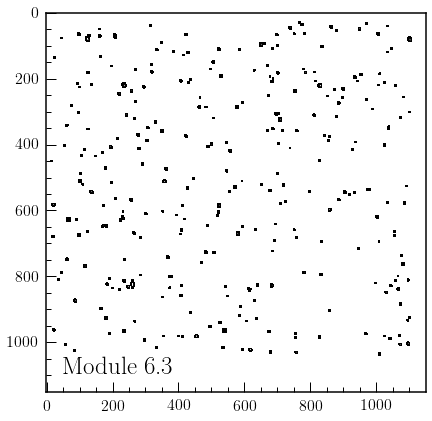

In [12]:
image = gen[0] # we can also access the representations by index

plt.imshow(image, cmap='Greys_r', interpolation='None')

plt.text(50, 1100, "Module {}.{}".format(ccd.module, ccd.channel+1), fontsize = 25)

In [13]:
np.shape(image)

(1150, 1150)

k2utils.py:209: RuntimeWarning: invalid value encountered in log10
  return np.log10(flux/1.74e5)/(-0.4)+12


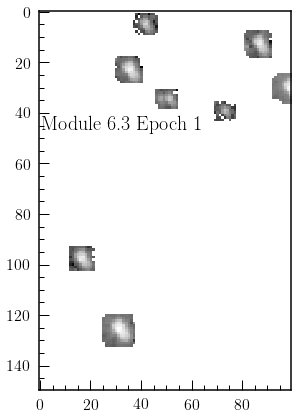

In [14]:
#plt.imshow(fluxToMag(image[50:100,100:150]), cmap='Greys', interpolation='None')
plt.imshow(fluxToMag(image[800:950,150:250]), cmap='Greys', interpolation='None')

plt.text(1, 47, "Module {}.{} Epoch 1".format(ccd.module, ccd.channel+1), fontsize = 20)